# Evaluation of the Classifier

This is the evaluation script of the classifier that outputs a vector of size 5.

### library and package importation

In [1]:
import random
import os
import shutil
import glob
import gc
import sys
import h5py
import time
import datetime
import pickle
import librosa
import warnings
import matplotlib.pyplot as plt

from graphs import draw
import graphs

import numpy as np
from numpy import array
import pandas as pd
from pandas.plotting import parallel_coordinates
from pydub import AudioSegment

#imported for testing
import wave
import contextlib

# for outputing file
from scipy.cluster.vq import vq, kmeans, whiten
import scipy.stats.stats as st

from sklearn.cluster import KMeans
from sklearn.datasets import make_classification
from sklearn.datasets.samples_generator import make_blobs
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import normalize
from sklearn.metrics import auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn import mixture
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.utils import class_weight

import keras

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.constraints import maxnorm
from keras.layers import Convolution1D, Dense, MaxPooling1D, Flatten, Add, Dropout, Input, Activation
from keras.layers import TimeDistributed, Bidirectional, LSTM, LeakyReLU
from keras.models import Sequential
from keras.models import load_model
from keras import optimizers, regularizers
from keras.utils import np_utils, to_categorical

from IPython.display import clear_output

# confirm TensorFlow sees the GPU
from tensorflow.python.client import device_lib
# assert 'GPU' in str(device_lib.list_local_devices())

# confirm Keras sees the GPU
from keras import backend
# print(len(backend.tensorflow_backend._get_available_gpus()) > 0)

sample_rate=44100
hop_length = 441  # frame size= 2*hop
segment_length=int(sample_rate*0.2)  #0.2
segment_pad=int(sample_rate*0.02)     #0.02
overlappiong=int(sample_rate*0.1)   #0.1

NumofFeaturetoUse = 272 # this will re-assigned for different classifiers
frame_number = 48

sys.path.insert(1, '..//components//')
import load_feat_directories

# input new indices file here
# indices_filename = 'D://indices_filename.npy'
# indices=np.load(indices_filename)

C:\Users\yg9ca\AppData\Local\Continuum\anaconda3\lib\site-packages\pydub\utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
Using TensorFlow backend.


In [2]:
def avail_modules(directory, prefix):
    module_names = []
    for item in os.listdir(directory):
        if prefix in item:
            module_names.append(directory + item)
            i = module_names.index(directory + item)
            print(str(i) + 'th module')
            print(directory + item)
    return module_names

In [3]:
def comprise_vector(path, dist, reverb, noise):
    vec_to_return = []
    for fname in os.listdir(path):
        components = fname.split('_')
        '''
        if dist == 0 and 'deamp' in components: continue
        if reverb == 0 and 'WetDry' in components: continue
        if noise == 0 and 'noise' in components: continue
        '''
        current_vec = np.load(path + fname)
        vec_to_return.append(current_vec)
        
    vec_to_return = np.array(vec_to_return)
    return vec_to_return

In [4]:
def comprise_label(feature_vector, label):
    label_vec_to_ret = []
    length = len(list(feature_vector))
    for index in range(0, length):
        current_label = [label]
        label_vec_to_ret.append(current_label)
    label_vec_to_ret = np.array(label_vec_to_ret)

    return label_vec_to_ret

def float_compatible(input_np):

    x = np.where(input_np >= np.finfo(np.float32).max)
    for index in range(0, len(x[0])):
        x_position = x[0][index]
        y_position = x[1][index]
        input_np[x_position, y_position] = 0.0
    input_np = np.nan_to_num(input_np)

    return input_np

def update_progress(progress):
    bar_length = 100
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))
    clear_output(wait = True)
    
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [5]:
# allnoised_npy[0, 1, 2, 3, 4] ==> H, A, N, S, O
# homenoised_npy[0, 1, 2, 3, 4] ==> H, A, N, S, O
all_noised_npy = load_feat_directories.allnoised_npy
all_noised_npy_test = load_feat_directories.allnoised_npy_test
home_noised_npy = load_feat_directories.homenoised_npy
home_noised_npy_test = load_feat_directories.homenoised_npy_test

for index in range(0, 5):
    if not os.path.exists(all_noised_npy_test[index]):
        print(all_noised_npy_test[index] + ' does not exist. Breaking the loop... ')
    if not os.path.exists(home_noised_npy[index]):
        print(home_noised_npy_test[index] + 'does not exist. Breaking the loop... ')

In [6]:
emotions = [0, 1, 2, 3, 4]
home_or_all = 'home'
dist = 0
reverb = 0
noise = 0

for index in emotions:
    if home_or_all == 'home':
        path = home_noised_npy_test[index]
    else:
        path = all_noised_npy_test[index]
        
    if index == 0:
        val_h_feat = comprise_vector(path, dist, reverb, noise)
        val_h_label = comprise_label(val_h_feat, index)
    elif index == 1:
        val_a_feat = comprise_vector(path, dist, reverb, noise)
        val_a_label = comprise_label(val_a_feat, index)
    elif index == 2:
        val_n_feat = comprise_vector(path, dist, reverb, noise)
        val_n_label = comprise_label(val_n_feat, index)
    elif index == 3:
        val_s_feat = comprise_vector(path, dist, reverb, noise)
        val_s_label = comprise_label(val_s_feat, index)
    else:
        val_o_feat = comprise_vector(path, dist, reverb, noise)
        val_o_label = comprise_label(val_o_feat, index)     


In [7]:
def max_index(a): 
  
    # inbuilt function to find the position of minimum  
    minpos = a.index(min(a)) 
      
    # inbuilt function to find the position of maximum  
    maxpos = a.index(max(a))  
      
    return maxpos

# Evaluation in different scenarios

In [55]:
def eval_all(emotionFolders):
    total = 0
    
    zero_scores = []
    one_scores = []
    two_scores = []
    three_scores = []
    four_scores = []
    
    correct = 0
    incorrect = 0
    
    for emotionFolder in emotionFolders:
        if 'Happy' in emotionFolder: val = 0
        elif 'Angry' in emotionFolder: val = 1
        elif 'Neutral' in emotionFolder: val = 2
        elif 'Sad' in emotionFolder: val = 3
        else: val = 4

        for emotionfile in os.listdir(emotionFolder):
            
            one_sample = np.load(emotionFolder + emotionfile)
            one_sample = np.array([one_sample])
            
            #zero_score, one_score, two_score, three_score, four_score = model.predict(one_sample)[0]
            four_score = -1
            zero_score, one_score, two_score, three_score = model.predict(one_sample)[0]
            zero_scores.append(zero_score)
            one_scores.append(one_score)
            two_scores.append(two_score)
            three_scores.append(three_score)
            four_scores.append(four_score)
            
            result_list = [zero_score, one_score, two_score, three_score, four_score]

            if val == max_index(result_list): correct += 1
            else: incorrect += 1

            total += 1
                
    print('correct = ' + str(correct))
    print('incorrect = ' + str(incorrect))
    print('error rate = ' + str(incorrect/total) )
    print('accuracy = ' + str(correct/total) )
    print('total files = ' + str(total))
                       
    mydict = {'one_scores': one_scores, 'zero_scores': zero_scores, \
              'two_scores': two_scores, 'three_scores': three_scores, \
              'four_scores': four_scores, \
             'error_rate': incorrect/total, 'accuracy': correct/total, 'total_files': total}
    return mydict

In [23]:
def eval_original(emotionFolders):
    total = 0
    
    zero_scores = []
    one_scores = []
    two_scores = []
    three_scores = []
    four_scores = []
    
    correct = 0
    incorrect = 0
    
    for emotionFolder in emotionFolders:
        
        if 'Happy' in emotionFolder: val = 0
        elif 'Angry' in emotionFolder: val = 1
        elif 'Neutral' in emotionFolder: val = 2
        elif 'Sad' in emotionFolder: val = 3
        else: val = 4

        for emotionfile in os.listdir(emotionFolder):
            dist = 'deamp_' in emotionfile
            reverb = 'WetDry_' in emotionfile and 'Diffusion_' in emotionfile and 'DecayFactor_' in emotionfile
            noise = 'noise_' in emotionfile
        
            r_n = not dist and reverb and noise 
            r = not dist and reverb and not noise
            n = not dist and not reverb and noise
            original = not dist and not reverb and not noise
            d_r_n = dist and reverb and noise
            d_r = dist and reverb and not noise
            d_n = dist and not reverb and noise
            d = dist and not reverb and not noise 
            
            if original:
                one_sample = np.load(emotionFolder + emotionfile)
                one_sample = np.array([one_sample])
                
                #zero_score, one_score, two_score, three_score, four_score = model.predict(one_sample)[0]
                four_score = -1
                zero_score, one_score, two_score, three_score = model.predict(one_sample)[0]
                zero_scores.append(zero_score)
                one_scores.append(one_score)
                two_scores.append(two_score)
                three_scores.append(three_score)
                four_scores.append(four_score)

                result_list = [zero_score, one_score, two_score, three_score, four_score]
                
                if val == max_index(result_list): correct += 1
                else: incorrect += 1
                
                total += 1
    
    print('correct = ' + str(correct))
    print('incorrect = ' + str(incorrect))
    print('error rate = ' + str(incorrect/total) )
    print('accuracy = ' + str(correct/total) )
    print('total files = ' + str(total))
                       
    mydict = {'one_scores': one_scores, 'zero_scores': zero_scores, \
              'two_scores': two_scores, 'three_scores': three_scores, \
              'four_scores': four_scores, \
             'error_rate': incorrect/total, 'accuracy': correct/total, 'total_files': total}
    return mydict

In [24]:
def eval_deamplified_noised(emotionFolders):
    total = 0
    
    zero_scores = []
    one_scores = []
    two_scores = []
    three_scores = []
    four_scores = []
    
    deamplified_dbs = []
    
    correct = 0
    incorrect = 0
    
    for emotionFolder in emotionFolders:
        if 'Happy' in emotionFolder: val = 0
        elif 'Angry' in emotionFolder: val = 1
        elif 'Neutral' in emotionFolder: val = 2
        elif 'Sad' in emotionFolder: val = 3
        else: val = 4

        for emotionfile in os.listdir(emotionFolder):
            dist = 'deamp_' in emotionfile
            reverb = 'WetDry_' in emotionfile and 'Diffusion_' in emotionfile and 'DecayFactor_' in emotionfile
            noise = 'noise_' in emotionfile
        
            r_n = not dist and reverb and noise 
            r = not dist and reverb and not noise
            n = not dist and not reverb and noise
            original = not dist and not reverb and not noise
            d_r_n = dist and reverb and noise
            d_r = dist and reverb and not noise
            d_n = dist and not reverb and noise
            d = dist and not reverb and not noise # does not exist
            
            if d_n:
                one_sample = np.load(emotionFolder + emotionfile)
                one_sample = np.array([one_sample])
                
                components = emotionfile.split('_')
                deamplified_amount_position = components.index('deamp') + 1
                deamplified = float(components[deamplified_amount_position])
                deamplified_dbs.append(deamplified)
                
                #zero_score, one_score, two_score, three_score, four_score = model.predict(one_sample)[0]
                
                four_score = -1
                zero_score, one_score, two_score, three_score = model.predict(one_sample)[0]
                zero_scores.append(zero_score)
                one_scores.append(one_score)
                two_scores.append(two_score)
                three_scores.append(three_score)
                four_scores.append(four_score)

                result_list = [zero_score, one_score, two_score, three_score, four_score]
                
                if val == max_index(result_list): correct += 1
                else: incorrect += 1
                
                total += 1
                
    print('correct = ' + str(correct))
    print('incorrect = ' + str(incorrect))
    print('error rate = ' + str(incorrect/total) )
    print('accuracy = ' + str(correct/total) )
    print('total files = ' + str(total))
                       
    mydict = {'one_scores': one_scores, 'zero_scores': zero_scores, \
              'two_scores': two_scores, 'three_scores': three_scores, \
              'four_scores': four_scores, \
             'deamplified_dbs': deamplified_dbs, 'error_rate': incorrect/total, 'accuracy': correct/total, \
             'total_files': total}
    return mydict

In [25]:
def eval_reverbed(emotionFolders):
    total = 0
    
    zero_scores = []
    one_scores = []
    two_scores = []
    three_scores = []
    four_scores = []
    
    wetdrys = []
    diffusions = []
    decayfactors = []
    
    
    correct = 0
    incorrect = 0
    
    for emotionFolder in emotionFolders:
        if 'Happy' in emotionFolder: val = 0
        elif 'Angry' in emotionFolder: val = 1
        elif 'Neutral' in emotionFolder: val = 2
        elif 'Sad' in emotionFolder: val = 3
        else: val = 4

        for emotionfile in os.listdir(emotionFolder):
            dist = 'deamp_' in emotionfile
            reverb = 'WetDry_' in emotionfile and 'Diffusion_' in emotionfile and 'DecayFactor_' in emotionfile
            noise = 'noise_' in emotionfile
        
            r_n = not dist and reverb and noise 
            r = not dist and reverb and not noise
            n = not dist and not reverb and noise
            original = not dist and not reverb and not noise
            d_r_n = dist and reverb and noise
            d_r = dist and reverb and not noise
            d_n = dist and not reverb and noise
            d = dist and not reverb and not noise # does not exist
            
            if r:
                one_sample = np.load(emotionFolder + emotionfile)
                one_sample = np.array([one_sample])
                #zero_score, one_score, two_score, three_score, four_score = model.predict(one_sample)[0]
                four_score = -1
                zero_score, one_score, two_score, three_score = model.predict(one_sample)[0]
                zero_scores.append(zero_score)
                one_scores.append(one_score)
                two_scores.append(two_score)
                three_scores.append(three_score)
                four_scores.append(four_score)

                result_list = [zero_score, one_score, two_score, three_score, four_score]
                
                components = emotionfile.split('_')
                
                wetdry_position = components.index('WetDry') + 1
                wetdrys.append(float(components[wetdry_position]))
                
                decayfactor_position = components.index('DecayFactor') + 1
                decayfactors.append(float(components[decayfactor_position]))
                
                diffusion_position = components.index('Diffusion') + 1
                diffusions.append(float(components[diffusion_position].split('.')[0]))
                
                zero_scores.append(zero_score)
                one_scores.append(one_score)
                
                if val == max_index(result_list): correct += 1
                else: incorrect += 1
                
                total += 1
    print('correct = ' + str(correct))
    print('incorrect = ' + str(incorrect))
    print('error rate = ' + str(incorrect/total) )
    print('accuracy = ' + str(correct/total) )
    print('total files = ' + str(total))
                       
    mydict = {'one_scores': one_scores, 'zero_scores': zero_scores, \
              'two_scores': two_scores, 'three_scores': three_scores, \
              'four_scores': four_scores, \
             'wetdrys': wetdrys, 'diffusions': diffusions, 'decayfactors': decayfactors, \
             'error_rate': incorrect/total, 'accuracy': correct/total, 'total_files': total}
    return mydict

In [26]:
def eval_deamplified_noised_reverbed(emotionFolders):
    total = 0
    
    zero_scores = []
    one_scores = []
    two_scores = []
    three_scores = []
    four_scores = []
    
    wetdrys = []
    diffusions = []
    decayfactors = []
    deamplified_dbs = []
    
    correct = 0
    incorrect = 0
    
    for emotionFolder in emotionFolders:
        if 'Happy' in emotionFolder: val = 0
        elif 'Angry' in emotionFolder: val = 1
        elif 'Neutral' in emotionFolder: val = 2
        elif 'Sad' in emotionFolder: val = 3
        else: val = 4

        for emotionfile in os.listdir(emotionFolder):
            dist = 'deamp_' in emotionfile
            reverb = 'WetDry_' in emotionfile and 'Diffusion_' in emotionfile and 'DecayFactor_' in emotionfile
            noise = 'noise_' in emotionfile
        
            r_n = not dist and reverb and noise 
            r = not dist and reverb and not noise
            n = not dist and not reverb and noise
            original = not dist and not reverb and not noise
            d_r_n = dist and reverb and noise
            d_r = dist and reverb and not noise
            d_n = dist and not reverb and noise
            d = dist and not reverb and not noise # does not exist
            
            if d_r_n:
                print(emotionfile)
                one_sample = np.load(emotionFolder + emotionfile)
                one_sample = np.array([one_sample])
                
                #zero_score, one_score, two_score, three_score, four_score = model.predict(one_sample)[0]
                four_score = -1
                zero_score, one_score, two_score, three_score = model.predict(one_sample)[0]
                zero_scores.append(zero_score)
                one_scores.append(one_score)
                two_scores.append(two_score)
                three_scores.append(three_score)
                four_scores.append(four_score)

                result_list = [zero_score, one_score, two_score, three_score, four_score]
                
                components = emotionfile.split('_')
                
                deamplified_position = components.index('deamp') + 1
                deamplified_dbs.append(float(components[deamplified_position]))
                
                wetdry_position = components.index('WetDry') + 1
                wetdrys.append(float(components[wetdry_position]))
                
                decayfactor_position = components.index('DecayFactor') + 1
                decayfactors.append(float(components[decayfactor_position]))
                
                diffusion_position = components.index('Diffusion') + 1
                diffusions.append(float(components[diffusion_position].split('.')[0]))
                
                zero_scores.append(zero_score)
                one_scores.append(one_score)
                
                if val == max_index(result_list): correct += 1
                else: incorrect += 1
                
                total += 1
    print('correct = ' + str(correct))
    print('incorrect = ' + str(incorrect))
    print('error rate = ' + str(incorrect/total) )
    print('accuracy = ' + str(correct/total))
    print('total files = ' + str(total))
                       
    mydict = {'one_scores': one_scores, 'zero_scores': zero_scores, \
              'two_scores': two_scores, 'three_scores': three_scores, \
              'four_scores': four_scores, \
             'wetdrys': wetdrys, 'diffusions': diffusions, 'decayfactors': decayfactors,
             'deamplified_dbs': deamplified_dbs, 'error_rate': incorrect/total, 'accuracy': correct/total, \
             'total_files': total}
    return mydict

In [27]:
def predict_cnn(model):
    y_pred = []
    y_true = []

    for item in list(Label_val):
            if item[0] > item[1]:
                y_true.append(0)
            elif item[0] < item[1]:
                y_true.append(1)
            else:
                y_true.append(0)

    for item in list(model.predict(featureSet_val)):
            if item[0] > item[1]:
                y_pred.append(0)
            elif item[0] < item[1]:
                y_pred.append(1)
            else:
                y_pred.append(0)

    print('Accuracy: ' + str(accuracy_score(y_true, y_pred)))
    print('Precision: ' + str(precision_score(y_true, y_pred)))
    print('Recall: ' + str(recall_score(y_true, y_pred)))
    print('f1 score: ' + str(f1_score(y_true, y_pred)))

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

In [14]:
# Load testing npy files
featureSet_val = float_compatible(np.vstack((val_h_feat, val_a_feat, val_n_feat, val_s_feat)))
Label_val = np.vstack((val_h_label, val_a_label, val_n_label, val_s_label))
Label_val[Label_val == 0] = 0
Label_val[Label_val == 1] = 1
Label_val[Label_val == 2] = 2
Label_val[Label_val == 3] = 3
Label_val[Label_val == 4] = 4
Label_val = to_categorical(Label_val)
print('evaluation data: ' + str(featureSet_val.shape))
print('evaluation label: ' + str(Label_val.shape))

evaluation data: (7551, 48, 272)
evaluation label: (7551, 4)


In [18]:
directory = '..//..//..//modules//'
module_prefix = 'Four_'
modules = avail_modules(directory, module_prefix)

0th module
..//..//..//modules//Checkpoint_home_All_neurons_home_1024_filters_2048_dropout_0.2_epoch_1000_dense_6.hdf5
1th module
..//..//..//modules//Checkpoint_home_All_neurons_home_2048_filters_1024_dropout_0.2_epoch_1000_dense_4.hdf5
2th module
..//..//..//modules//Checkpoint_home_All_neurons_home_2048_filters_2048_dropout_0.2_epoch_1000_dense_8.hdf5
3th module
..//..//..//modules//Checkpoint_home_All_neurons_home_4096_filters_3072_dropout_0.2_epoch_1000_dense_10.hdf5
4th module
..//..//..//modules//Checkpoint_home_Four_neurons_home_4096_filters_3072_dropout_0.2_epoch_1000_dense_10.hdf5
5th module
..//..//..//modules//Checkpoint_home_Four_neurons_home_4096_filters_3072_dropout_0.2_epoch_1000_dense_10_penultimate_emprical_means.npy


In [19]:
title = modules[4]
model = keras.models.load_model(title)

In [17]:
# model.summary()

## Specify the directories that contain the files of emotion

In [28]:
emotionFolders = [home_noised_npy_test[0], home_noised_npy_test[1], \
                  home_noised_npy_test[2], home_noised_npy_test[3], home_noised_npy_test[4]]

## Only evaluate unmodified wav files

### evaluate the set of Happy validation

In [29]:
dictionary_original_h = eval_original([emotionFolders[0]])
zero_scores_original_h = dictionary_original_h.get('zero_scores')

correct = 333
incorrect = 7
error rate = 0.020588235294117647
accuracy = 0.9794117647058823
total files = 340


### evaluate the set of Angry validation

In [30]:
dictionary_original_a = eval_original([emotionFolders[1]])
one_scores_original_a = dictionary_original_a.get('one_scores')

correct = 305
incorrect = 21
error rate = 0.06441717791411043
accuracy = 0.9355828220858896
total files = 326


### evaluate the set of Neutral validation

In [31]:
dictionary_original_n = eval_original([emotionFolders[2]])
two_scores_original_n = dictionary_original_n.get('two_scores')

correct = 285
incorrect = 14
error rate = 0.046822742474916385
accuracy = 0.9531772575250836
total files = 299


### evaluate the set of Sad validation

In [32]:
dictionary_original_s = eval_original([emotionFolders[3]])
three_scores_original_n = dictionary_original_s.get('three_scores')

correct = 323
incorrect = 12
error rate = 0.03582089552238806
accuracy = 0.9641791044776119
total files = 335


### evaluate the set of Other validation

In [33]:
dictionary_original_o = eval_original([emotionFolders[4]])
three_scores_original_o = dictionary_original_o.get('four_scores')

correct = 0
incorrect = 326
error rate = 1.0
accuracy = 0.0
total files = 326


### draw the plot (evaluation on only unmodified, original wav files)

(<Figure size 662.4x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2e10bcd3908>)

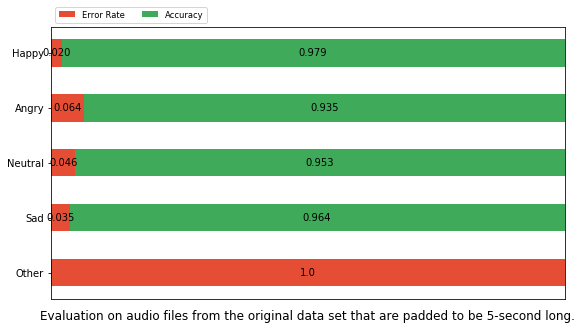

In [34]:
category_names = ['Error Rate', 'Accuracy']
graph_title = 'Evaluation on audio files from the original data set that are padded to be 5-second long.'
results = {
    'Happy': [dictionary_original_h.get('error_rate'), dictionary_original_h.get('accuracy')],
    'Angry': [dictionary_original_a.get('error_rate'), dictionary_original_a.get('accuracy')],
    'Neutral': [dictionary_original_n.get('error_rate'), dictionary_original_n.get('accuracy')],
    'Sad': [dictionary_original_s.get('error_rate'), dictionary_original_s.get('accuracy')],
    'Other': [dictionary_original_o.get('error_rate'), dictionary_original_o.get('accuracy')]
}

draw(results, category_names, graph_title)

## Only evaluate reverberated wav files

### evaluate the set of Happy validation

In [35]:
dictionary_reverbed_h = eval_reverbed([emotionFolders[0]])
wetdrys_reverbed_h = dictionary_reverbed_h.get('wetdrys')
diffusions_reverbed_h = dictionary_reverbed_h.get('diffusions')
decayfactors_reverbed_h = dictionary_reverbed_h.get('decayfactors')

correct = 322
incorrect = 23
error rate = 0.06666666666666667
accuracy = 0.9333333333333333
total files = 345


### evaluate the set of Angry validation

In [36]:
dictionary_reverbed_a = eval_reverbed([emotionFolders[1]])
wetdrys_reverbed_a = dictionary_reverbed_a.get('wetdrys')
diffusions_reverbed_a = dictionary_reverbed_a.get('diffusions')
decayfactors_reverbed_a = dictionary_reverbed_a.get('decayfactors')

correct = 270
incorrect = 47
error rate = 0.14826498422712933
accuracy = 0.8517350157728707
total files = 317


### evaluate the set of Neutral validation

In [37]:
dictionary_reverbed_n = eval_reverbed([emotionFolders[2]])
wetdrys_reverbed_n = dictionary_reverbed_n.get('wetdrys')
diffusions_reverbed_n = dictionary_reverbed_n.get('diffusions')
decayfactors_reverbed_n = dictionary_reverbed_n.get('decayfactors')

correct = 243
incorrect = 38
error rate = 0.13523131672597866
accuracy = 0.8647686832740213
total files = 281


### evaluate the set of Sad validation

In [38]:
dictionary_reverbed_s = eval_reverbed([emotionFolders[3]])
wetdrys_reverbed_s = dictionary_reverbed_s.get('wetdrys')
diffusions_reverbed_s = dictionary_reverbed_s.get('diffusions')
decayfactors_reverbed_s = dictionary_reverbed_s.get('decayfactors')

correct = 301
incorrect = 25
error rate = 0.07668711656441718
accuracy = 0.9233128834355828
total files = 326


### evaluate the set of Other validation

In [39]:
dictionary_reverbed_o = eval_reverbed([emotionFolders[4]])
wetdrys_reverbed_o = dictionary_reverbed_o.get('wetdrys')
diffusions_reverbed_o = dictionary_reverbed_o.get('diffusions')
decayfactors_reverbed_o = dictionary_reverbed_o.get('decayfactors')

correct = 0
incorrect = 279
error rate = 1.0
accuracy = 0.0
total files = 279


### draw the plot (evaluation on only the reverberated wav files)

(<Figure size 662.4x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2e217004cc8>)

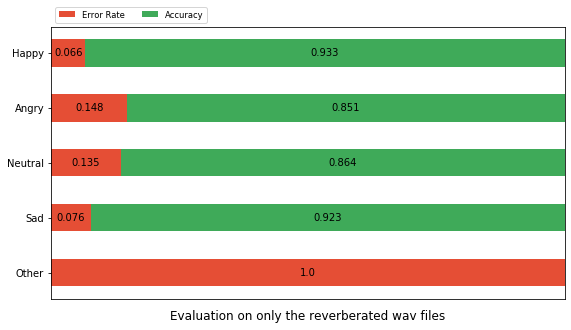

In [40]:
category_names = ['Error Rate', 'Accuracy']
graph_title = 'Evaluation on only the reverberated wav files'
results = {
    'Happy': [dictionary_reverbed_h.get('error_rate'), dictionary_reverbed_h.get('accuracy')],
    'Angry': [dictionary_reverbed_a.get('error_rate'), dictionary_reverbed_a.get('accuracy')],
    'Neutral': [dictionary_reverbed_n.get('error_rate'), dictionary_reverbed_n.get('accuracy')],
    'Sad': [dictionary_reverbed_s.get('error_rate'), dictionary_reverbed_s.get('accuracy')],
    'Other': [dictionary_reverbed_o.get('error_rate'), dictionary_reverbed_o.get('accuracy')]
}

draw(results, category_names, graph_title)

## Only evaluate deamplified and noised wav files

### evaluate the set of Happy validation

In [41]:
dictionary_deamplified_noised_h = eval_deamplified_noised([emotionFolders[0]])

one_scores_deamplified_noised_h = dictionary_deamplified_noised_h.get('one_scores')
zero_scores_deamplified_noised_h = dictionary_deamplified_noised_h.get('zero_scores')
deamplified_dbs_deamplified_noised_h = dictionary_deamplified_noised_h.get('deamplified_dbs')
wetdrys_deamplified_noised_h = dictionary_deamplified_noised_h.get('wetdrys')
diffusions_deamplified_noised_h = dictionary_deamplified_noised_h.get('diffusions')
decayfactors_deamplified_noised_h = dictionary_deamplified_noised_h.get('decayfactors')

correct = 570
incorrect = 25
error rate = 0.04201680672268908
accuracy = 0.957983193277311
total files = 595


### evaluate the set of Angry validation

In [42]:
dictionary_deamplified_noised_a = eval_deamplified_noised([emotionFolders[1]])

one_scores_deamplified_noised_a = dictionary_deamplified_noised_a.get('one_scores')
zero_scores_deamplified_noised_a = dictionary_deamplified_noised_a.get('zero_scores')
deamplified_dbs_deamplified_noised_a = dictionary_deamplified_noised_a.get('deamplified_dbs')
wetdrys_deamplified_noised_a = dictionary_deamplified_noised_a.get('wetdrys')
diffusions_deamplified_noised_a = dictionary_deamplified_noised_a.get('diffusions')
decayfactors_deamplified_noised_a = dictionary_deamplified_noised_a.get('decayfactors')

correct = 560
incorrect = 74
error rate = 0.1167192429022082
accuracy = 0.8832807570977917
total files = 634


### evaluate the set of Neutral validation

In [43]:
dictionary_deamplified_noised_n = eval_deamplified_noised([emotionFolders[2]])

one_scores_deamplified_noised_n = dictionary_deamplified_noised_n.get('one_scores')
zero_scores_deamplified_noised_n = dictionary_deamplified_noised_n.get('zero_scores')
deamplified_dbs_deamplified_noised_n = dictionary_deamplified_noised_n.get('deamplified_dbs')
wetdrys_deamplified_noised_n = dictionary_deamplified_noised_n.get('wetdrys')
diffusions_deamplified_noised_n = dictionary_deamplified_noised_n.get('diffusions')
decayfactors_deamplified_noised_n = dictionary_deamplified_noised_n.get('decayfactors')

correct = 538
incorrect = 43
error rate = 0.07401032702237521
accuracy = 0.9259896729776248
total files = 581


### evaluate the set of Sad validation

In [44]:
dictionary_deamplified_noised_s = eval_deamplified_noised([emotionFolders[3]])

one_scores_deamplified_noised_s = dictionary_deamplified_noised_s.get('one_scores')
zero_scores_deamplified_noised_s = dictionary_deamplified_noised_s.get('zero_scores')
deamplified_dbs_deamplified_noised_s = dictionary_deamplified_noised_s.get('deamplified_dbs')
wetdrys_deamplified_noised_s = dictionary_deamplified_noised_s.get('wetdrys')
diffusions_deamplified_noised_s = dictionary_deamplified_noised_s.get('diffusions')
decayfactors_deamplified_noised_s = dictionary_deamplified_noised_s.get('decayfactors')

correct = 585
incorrect = 47
error rate = 0.07436708860759493
accuracy = 0.9256329113924051
total files = 632


### evaluate the set of Other validation

In [45]:
dictionary_deamplified_noised_o = eval_deamplified_noised([emotionFolders[4]])

one_scores_deamplified_noised_o = dictionary_deamplified_noised_o.get('one_scores')
zero_scores_deamplified_noised_o = dictionary_deamplified_noised_o.get('zero_scores')
deamplified_dbs_deamplified_noised_o = dictionary_deamplified_noised_o.get('deamplified_dbs')
wetdrys_deamplified_noised_o = dictionary_deamplified_noised_o.get('wetdrys')
diffusions_deamplified_noised_o = dictionary_deamplified_noised_o.get('diffusions')
decayfactors_deamplified_noised_o = dictionary_deamplified_noised_o.get('decayfactors')

correct = 0
incorrect = 687
error rate = 1.0
accuracy = 0.0
total files = 687


### draw the plot (evaluation on only the wav files that are deamplified and mixed with noise)

(<Figure size 662.4x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2e21712bcc8>)

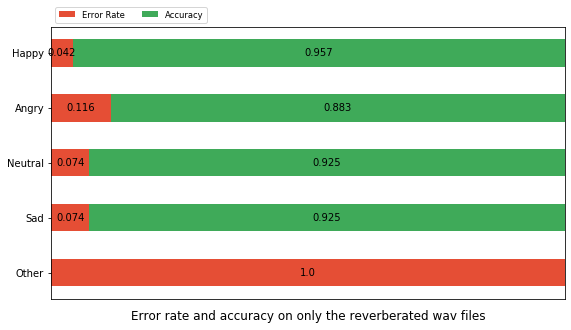

In [46]:
category_names = ['Error Rate', 'Accuracy']
graph_title = 'Error rate and accuracy on only the reverberated wav files'
results = {
    'Happy': [dictionary_deamplified_noised_h.get('error_rate'), dictionary_deamplified_noised_h.get('accuracy')],
    'Angry': [dictionary_deamplified_noised_a.get('error_rate'), dictionary_deamplified_noised_a.get('accuracy')],
    'Neutral': [dictionary_deamplified_noised_n.get('error_rate'), dictionary_deamplified_noised_n.get('accuracy')],
    'Sad': [dictionary_deamplified_noised_s.get('error_rate'), dictionary_deamplified_noised_s.get('accuracy')],
    'Other': [dictionary_deamplified_noised_o.get('error_rate'), dictionary_deamplified_noised_o.get('accuracy')]
}

draw(results, category_names, graph_title)

In [47]:
h = [deamplified_dbs_deamplified_noised_h, zero_scores_deamplified_noised_h]
a = [deamplified_dbs_deamplified_noised_a, zero_scores_deamplified_noised_a]
n = [deamplified_dbs_deamplified_noised_n, one_scores_deamplified_noised_n]
s = [deamplified_dbs_deamplified_noised_s, one_scores_deamplified_noised_s]
o = [deamplified_dbs_deamplified_noised_o, one_scores_deamplified_noised_o]

title = 'How deamplification affects the performance of the classifier in the presence of background noise'
xlabel = 'Deamplified amount measured in decibels'
ylabel = 'Score on the ground truth class of an audio clip'
#graphs.draw_scatter(h, a, n, s, title, xlabel, ylabel)


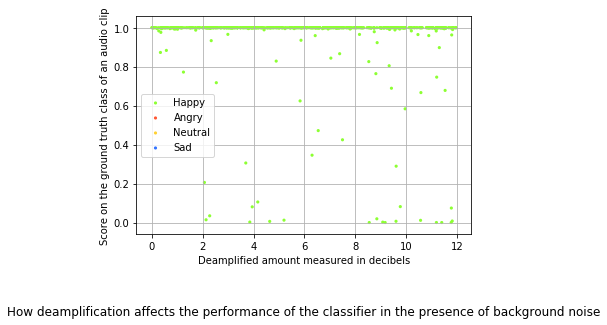

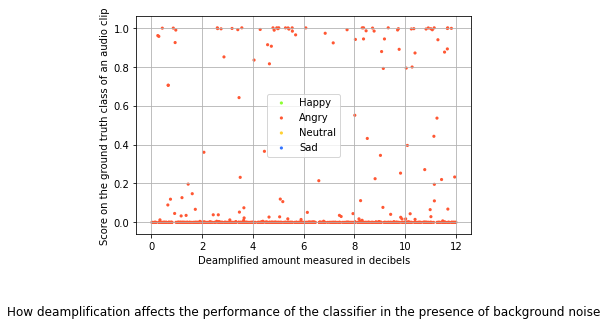

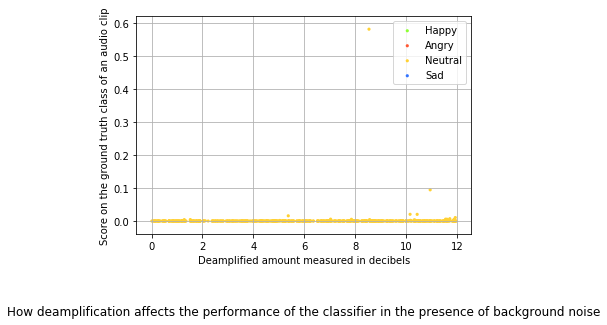

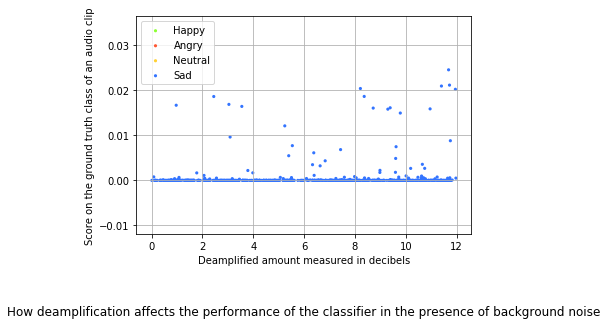

In [48]:
graphs.draw_scatter(h, [[],[]], [[],[]], [[],[]], title, xlabel, ylabel)
graphs.draw_scatter([[],[]], a, [[],[]], [[],[]], title, xlabel, ylabel)
graphs.draw_scatter([[],[]], [[],[]], n, [[],[]], title, xlabel, ylabel)
graphs.draw_scatter([[],[]], [[],[]], [[],[]], s, title, xlabel, ylabel)

## Only evaluate deamplified and noised and reverberated wav files

### evaluate the set of Happy validation

In [49]:
dictionary_deamplified_noised_reverbed_h = eval_deamplified_noised_reverbed([emotionFolders[0]])

one_scores_deamplified_noised_reverbed_h = dictionary_deamplified_noised_reverbed_h.get('one_scores')
zero_scores_deamplified_noised_reverbed_h = dictionary_deamplified_noised_reverbed_h.get('zero_scores')
deamplified_dbs_deamplified_noised_reverbed_h = dictionary_deamplified_noised_reverbed_h.get('deamplified_dbs')
wetdrys_deamplified_noised_reverbed_h = dictionary_deamplified_noised_reverbed_h.get('wetdrys')
diffusions_deamplified_noised_reverbed_h = dictionary_deamplified_noised_reverbed_h.get('diffusions')
decayfactors_deamplified_noised_reverbed_h = dictionary_deamplified_noised_reverbed_h.get('decayfactors')

deamp_0.011054264317365003_noise_home_81_Happy929_WetDry_4_DecayFactor_2_Diffusion_5.npy
deamp_0.014192512034123084_noise_home_81_Happy175_WetDry_4_DecayFactor_6_Diffusion_3.npy
deamp_0.014526914630268895_noise_home_25_Happy1706_WetDry_8_DecayFactor_8_Diffusion_2.npy
deamp_0.021837760502903425_noise_home_23_Happy229_WetDry_6_DecayFactor_6_Diffusion_3.npy
deamp_0.02750553957023749_noise_home_81_Happy1515_WetDry_4_DecayFactor_4_Diffusion_4.npy
deamp_0.028199437759590662_noise_home_81_Happy686_WetDry_2_DecayFactor_2_Diffusion_4.npy
deamp_0.060114409944866054_noise_home_83_Happy454_WetDry_4_DecayFactor_8_Diffusion_6.npy
deamp_0.07416615234112278_noise_home_81_Happy888_WetDry_8_DecayFactor_8_Diffusion_4.npy
deamp_0.11604605516270139_noise_home_80_Happy256_WetDry_4_DecayFactor_4_Diffusion_2.npy
deamp_0.1317813773672296_noise_home_25_Happy471_WetDry_4_DecayFactor_8_Diffusion_2.npy
deamp_0.13270127194375236_noise_home_25_Happy1320_WetDry_4_DecayFactor_4_Diffusion_4.npy
deamp_0.1354609598589031

deamp_1.3408541582737632_noise_home_81_Happy130_WetDry_2_DecayFactor_8_Diffusion_6.npy
deamp_1.342663588091832_noise_home_81_Happy1606_WetDry_8_DecayFactor_6_Diffusion_5.npy
deamp_1.3500344137743894_noise_home_88_Happy1588_WetDry_2_DecayFactor_6_Diffusion_6.npy
deamp_1.3801157306318363_noise_home_81_Happy307_WetDry_4_DecayFactor_6_Diffusion_3.npy
deamp_1.407640596227346_noise_home_24_Happy319_WetDry_4_DecayFactor_4_Diffusion_2.npy
deamp_1.45342470382668_noise_home_24_Happy184_WetDry_8_DecayFactor_4_Diffusion_6.npy
deamp_1.4588218436432334_noise_home_81_Happy504_WetDry_8_DecayFactor_4_Diffusion_3.npy
deamp_1.4833376313286197_noise_home_83_Happy807_WetDry_4_DecayFactor_8_Diffusion_6.npy
deamp_1.499737475431893_noise_home_25_Happy1182_WetDry_2_DecayFactor_6_Diffusion_2.npy
deamp_1.5461123935742558_noise_home_82_Happy1369_WetDry_4_DecayFactor_4_Diffusion_2.npy
deamp_1.5490898982851347_noise_home_80_Happy1349_WetDry_6_DecayFactor_6_Diffusion_2.npy
deamp_1.556310539061113_noise_home_81_Happy

deamp_11.06538754825013_noise_home_23_Happy1401_WetDry_2_DecayFactor_4_Diffusion_4.npy
deamp_11.068541211768753_noise_home_2_Happy489_WetDry_6_DecayFactor_2_Diffusion_4.npy
deamp_11.069416378972416_noise_home_88_Happy1208_WetDry_6_DecayFactor_6_Diffusion_2.npy
deamp_11.17883463906485_noise_home_81_Happy591_WetDry_2_DecayFactor_6_Diffusion_6.npy
deamp_11.199775005954475_noise_home_23_Happy657_WetDry_4_DecayFactor_6_Diffusion_2.npy
deamp_11.205092589334951_noise_home_25_Happy834_WetDry_6_DecayFactor_4_Diffusion_2.npy
deamp_11.207905511303043_noise_home_27_Happy653_WetDry_4_DecayFactor_8_Diffusion_6.npy
deamp_11.24596666215513_noise_home_23_Happy368_WetDry_8_DecayFactor_4_Diffusion_4.npy
deamp_11.255575226818296_noise_home_22_Happy879_WetDry_4_DecayFactor_2_Diffusion_5.npy
deamp_11.263821208844892_noise_home_27_Happy1121_WetDry_4_DecayFactor_4_Diffusion_4.npy
deamp_11.278230146574812_noise_home_25_Happy1766_WetDry_4_DecayFactor_4_Diffusion_2.npy
deamp_11.292860720137254_noise_home_2_Happy

deamp_2.7777639605959794_noise_home_2_Happy1506_WetDry_8_DecayFactor_8_Diffusion_2.npy
deamp_2.8540075622594507_noise_home_81_Happy1179_WetDry_8_DecayFactor_4_Diffusion_2.npy
deamp_2.8572079108791675_noise_home_2_Happy1618_WetDry_6_DecayFactor_4_Diffusion_3.npy
deamp_2.896809954403954_noise_home_82_Happy581_WetDry_6_DecayFactor_4_Diffusion_5.npy
deamp_2.9180469793195942_noise_home_80_Happy1594_WetDry_6_DecayFactor_8_Diffusion_5.npy
deamp_2.925982541204103_noise_home_81_Happy577_WetDry_4_DecayFactor_4_Diffusion_5.npy
deamp_2.95199285511283_noise_home_26_Happy756_WetDry_4_DecayFactor_4_Diffusion_6.npy
deamp_2.965965545302029_noise_home_83_Happy793_WetDry_8_DecayFactor_4_Diffusion_6.npy
deamp_2.994514623358175_noise_home_23_Happy554_WetDry_8_DecayFactor_4_Diffusion_4.npy
deamp_3.0134772610166376_noise_home_83_Happy1225_WetDry_8_DecayFactor_8_Diffusion_5.npy
deamp_3.0150600901230677_noise_home_80_Happy959_WetDry_4_DecayFactor_4_Diffusion_4.npy
deamp_3.042656489058959_noise_home_2_Happy238_

deamp_4.421099764643375_noise_home_27_Happy1123_WetDry_4_DecayFactor_4_Diffusion_2.npy
deamp_4.433793172011677_noise_home_81_Happy410_WetDry_2_DecayFactor_4_Diffusion_4.npy
deamp_4.508502094727566_noise_home_24_Happy731_WetDry_2_DecayFactor_4_Diffusion_4.npy
deamp_4.522453275678653_noise_home_25_Happy113_WetDry_6_DecayFactor_2_Diffusion_5.npy
deamp_4.526405414358497_noise_home_83_Happy1582_WetDry_8_DecayFactor_8_Diffusion_3.npy
deamp_4.53017957960037_noise_home_23_Happy638_WetDry_4_DecayFactor_6_Diffusion_2.npy
deamp_4.579177612349543_noise_home_26_Happy129_WetDry_6_DecayFactor_4_Diffusion_5.npy
deamp_4.586603095042838_noise_home_25_Happy452_WetDry_4_DecayFactor_6_Diffusion_5.npy
deamp_4.599332736837555_noise_home_24_Happy347_WetDry_2_DecayFactor_4_Diffusion_3.npy
deamp_4.600323387931857_noise_home_22_Happy854_WetDry_4_DecayFactor_6_Diffusion_2.npy
deamp_4.62691414167476_noise_home_2_Happy829_WetDry_8_DecayFactor_6_Diffusion_3.npy
deamp_4.6349642806323175_noise_home_2_Happy1161_WetDry_

deamp_6.183362393298671_noise_home_80_Happy1261_WetDry_2_DecayFactor_8_Diffusion_5.npy
deamp_6.216434180861134_noise_home_23_Happy150_WetDry_2_DecayFactor_4_Diffusion_6.npy
deamp_6.225281056948872_noise_home_81_Happy1297_WetDry_4_DecayFactor_4_Diffusion_4.npy
deamp_6.234421517577968_noise_home_26_Happy890_WetDry_4_DecayFactor_6_Diffusion_2.npy
deamp_6.265231891840294_noise_home_82_Happy606_WetDry_8_DecayFactor_4_Diffusion_4.npy
deamp_6.269455580881426_noise_home_82_Happy1462_WetDry_8_DecayFactor_4_Diffusion_2.npy
deamp_6.284695620398588_noise_home_81_Happy271_WetDry_4_DecayFactor_4_Diffusion_2.npy
deamp_6.309885524086278_noise_home_82_Happy685_WetDry_4_DecayFactor_4_Diffusion_2.npy
deamp_6.3187838009511745_noise_home_81_Happy1264_WetDry_2_DecayFactor_2_Diffusion_2.npy
deamp_6.327777169895183_noise_home_23_Happy497_WetDry_2_DecayFactor_2_Diffusion_6.npy
deamp_6.357514691440393_noise_home_82_Happy826_WetDry_4_DecayFactor_6_Diffusion_4.npy
deamp_6.3578486712908955_noise_home_80_Happy229_W

deamp_8.001968554807712_noise_home_80_Happy1460_WetDry_4_DecayFactor_6_Diffusion_5.npy
deamp_8.021662977379972_noise_home_23_Happy1163_WetDry_4_DecayFactor_6_Diffusion_2.npy
deamp_8.024650064537104_noise_home_80_Happy727_WetDry_2_DecayFactor_8_Diffusion_4.npy
deamp_8.03650566495805_noise_home_2_Happy678_WetDry_2_DecayFactor_6_Diffusion_5.npy
deamp_8.036635973930059_noise_home_81_Happy55_WetDry_2_DecayFactor_4_Diffusion_2.npy
deamp_8.045574598099552_noise_home_23_Happy1735_WetDry_6_DecayFactor_4_Diffusion_2.npy
deamp_8.046928236109654_noise_home_27_Happy1488_WetDry_2_DecayFactor_8_Diffusion_4.npy
deamp_8.08003944559165_noise_home_80_Happy310_WetDry_4_DecayFactor_8_Diffusion_5.npy
deamp_8.088740604428956_noise_home_25_Happy375_WetDry_4_DecayFactor_6_Diffusion_6.npy
deamp_8.111277040014382_noise_home_82_Happy1500_WetDry_2_DecayFactor_2_Diffusion_2.npy
deamp_8.123094321465105_noise_home_82_Happy956_WetDry_6_DecayFactor_6_Diffusion_5.npy
deamp_8.132594373624386_noise_home_24_Happy1553_WetDr

deamp_9.53305862351501_noise_home_88_Happy856_WetDry_8_DecayFactor_2_Diffusion_4.npy
deamp_9.54986324359625_noise_home_82_Happy1077_WetDry_6_DecayFactor_8_Diffusion_4.npy
deamp_9.555805376476155_noise_home_81_Happy1688_WetDry_8_DecayFactor_2_Diffusion_3.npy
deamp_9.569382024829746_noise_home_88_Happy533_WetDry_2_DecayFactor_2_Diffusion_2.npy
deamp_9.606759655041241_noise_home_2_Happy594_WetDry_4_DecayFactor_6_Diffusion_3.npy
deamp_9.620367994445193_noise_home_80_Happy1772_WetDry_4_DecayFactor_4_Diffusion_6.npy
deamp_9.650043809157104_noise_home_83_Happy1177_WetDry_2_DecayFactor_2_Diffusion_2.npy
deamp_9.651162233058177_noise_home_2_Happy1564_WetDry_4_DecayFactor_4_Diffusion_5.npy
deamp_9.66215367665341_noise_home_81_Happy46_WetDry_6_DecayFactor_2_Diffusion_6.npy
deamp_9.670243688172516_noise_home_23_Happy758_WetDry_6_DecayFactor_2_Diffusion_4.npy
deamp_9.69637214328564_noise_home_83_Happy649_WetDry_6_DecayFactor_8_Diffusion_2.npy
deamp_9.750972868212289_noise_home_24_Happy1300_WetDry_4

### evaluate the set of Angry validation

In [50]:
dictionary_deamplified_noised_reverbed_a = eval_deamplified_noised_reverbed([emotionFolders[1]])

one_scores_deamplified_noised_reverbed_a = dictionary_deamplified_noised_reverbed_a.get('one_scores')
zero_scores_deamplified_noised_reverbed_a = dictionary_deamplified_noised_reverbed_a.get('zero_scores')
deamplified_dbs_deamplified_noised_reverbed_a = dictionary_deamplified_noised_reverbed_a.get('deamplified_dbs')
wetdrys_deamplified_noised_reverbed_a = dictionary_deamplified_noised_reverbed_a.get('wetdrys')
diffusions_deamplified_noised_reverbed_a = dictionary_deamplified_noised_reverbed_a.get('diffusions')
decayfactors_deamplified_noised_reverbed_a = dictionary_deamplified_noised_reverbed_a.get('decayfactors')

deamp_0.04319807272977716_noise_home_80_Angry1549_WetDry_4_DecayFactor_4_Diffusion_6.npy
deamp_0.0479929074319938_noise_home_81_Angry1334_WetDry_2_DecayFactor_6_Diffusion_6.npy
deamp_0.11050023318166247_noise_home_80_Angry1761_WetDry_2_DecayFactor_6_Diffusion_4.npy
deamp_0.1235547832558681_noise_home_2_Angry1512_WetDry_2_DecayFactor_2_Diffusion_5.npy
deamp_0.13859267440574818_noise_home_26_Angry710_WetDry_4_DecayFactor_4_Diffusion_2.npy
deamp_0.13980122465164735_noise_home_82_Angry594_WetDry_2_DecayFactor_4_Diffusion_5.npy
deamp_0.18483921384310564_noise_home_82_Angry702_WetDry_2_DecayFactor_8_Diffusion_6.npy
deamp_0.1869716198845084_noise_home_81_Angry848_WetDry_2_DecayFactor_8_Diffusion_2.npy
deamp_0.19903161101365674_noise_home_25_Angry67_WetDry_2_DecayFactor_6_Diffusion_4.npy
deamp_0.23264234660962657_noise_home_23_Angry86_WetDry_2_DecayFactor_2_Diffusion_5.npy
deamp_0.2371335101452905_noise_home_83_Angry1556_WetDry_8_DecayFactor_4_Diffusion_4.npy
deamp_0.2489304815988609_noise_hom

deamp_1.70775417987951_noise_home_83_Angry1448_WetDry_4_DecayFactor_6_Diffusion_6.npy
deamp_1.7127407210352343_noise_home_23_Angry143_WetDry_8_DecayFactor_6_Diffusion_2.npy
deamp_1.729494611581175_noise_home_80_Angry1580_WetDry_2_DecayFactor_6_Diffusion_3.npy
deamp_1.7554405170425116_noise_home_82_Angry1084_WetDry_2_DecayFactor_2_Diffusion_5.npy
deamp_1.7615671321166588_noise_home_82_Angry1767_WetDry_6_DecayFactor_4_Diffusion_3.npy
deamp_1.767020931959972_noise_home_83_Angry553_WetDry_4_DecayFactor_8_Diffusion_3.npy
deamp_1.7678804122726883_noise_home_2_Angry1078_WetDry_4_DecayFactor_8_Diffusion_3.npy
deamp_1.7900106268135012_noise_home_26_Angry1170_WetDry_4_DecayFactor_4_Diffusion_5.npy
deamp_1.848547331299975_noise_home_25_Angry1788_WetDry_4_DecayFactor_6_Diffusion_4.npy
deamp_1.8548974774923161_noise_home_23_Angry647_WetDry_8_DecayFactor_6_Diffusion_5.npy
deamp_1.859531816136288_noise_home_81_Angry1180_WetDry_2_DecayFactor_8_Diffusion_3.npy
deamp_1.8653956468998487_noise_home_23_Ang

deamp_11.501280783914062_noise_home_2_Angry703_WetDry_2_DecayFactor_8_Diffusion_6.npy
deamp_11.517513973209176_noise_home_23_Angry681_WetDry_6_DecayFactor_6_Diffusion_4.npy
deamp_11.543324509182705_noise_home_83_Angry320_WetDry_4_DecayFactor_6_Diffusion_3.npy
deamp_11.546398851034276_noise_home_23_Angry600_WetDry_6_DecayFactor_8_Diffusion_3.npy
deamp_11.5628612597202_noise_home_83_Angry787_WetDry_2_DecayFactor_4_Diffusion_2.npy
deamp_11.579534992048634_noise_home_2_Angry1699_WetDry_8_DecayFactor_6_Diffusion_4.npy
deamp_11.586218477864463_noise_home_81_Angry280_WetDry_8_DecayFactor_6_Diffusion_5.npy
deamp_11.591386176171623_noise_home_81_Angry1728_WetDry_6_DecayFactor_4_Diffusion_6.npy
deamp_11.608657065783731_noise_home_26_Angry565_WetDry_4_DecayFactor_8_Diffusion_2.npy
deamp_11.61273470314208_noise_home_27_Angry1652_WetDry_6_DecayFactor_2_Diffusion_3.npy
deamp_11.63145730425499_noise_home_80_Angry1781_WetDry_8_DecayFactor_6_Diffusion_6.npy
deamp_11.672091423378044_noise_home_88_Angry9

deamp_3.4591751296151045_noise_home_83_Angry204_WetDry_8_DecayFactor_6_Diffusion_5.npy
deamp_3.5145253191362036_noise_home_23_Angry509_WetDry_8_DecayFactor_4_Diffusion_5.npy
deamp_3.5149405545293626_noise_home_82_Angry687_WetDry_6_DecayFactor_4_Diffusion_5.npy
deamp_3.565555051675583_noise_home_24_Angry1221_WetDry_8_DecayFactor_8_Diffusion_4.npy
deamp_3.5669420623934758_noise_home_83_Angry326_WetDry_8_DecayFactor_6_Diffusion_4.npy
deamp_3.584036000714425_noise_home_80_Angry1370_WetDry_8_DecayFactor_8_Diffusion_2.npy
deamp_3.589389781524111_noise_home_25_Angry297_WetDry_6_DecayFactor_8_Diffusion_6.npy
deamp_3.590081918009308_noise_home_81_Angry1606_WetDry_2_DecayFactor_6_Diffusion_5.npy
deamp_3.6364720737349794_noise_home_24_Angry429_WetDry_4_DecayFactor_4_Diffusion_6.npy
deamp_3.6425088291167516_noise_home_83_Angry191_WetDry_4_DecayFactor_8_Diffusion_6.npy
deamp_3.6469420533403087_noise_home_80_Angry46_WetDry_4_DecayFactor_4_Diffusion_4.npy
deamp_3.6541497201478648_noise_home_81_Angry1

deamp_4.863455897388324_noise_home_23_Angry1298_WetDry_4_DecayFactor_8_Diffusion_6.npy
deamp_4.923993529772803_noise_home_25_Angry717_WetDry_8_DecayFactor_2_Diffusion_5.npy
deamp_4.940016416074217_noise_home_24_Angry1278_WetDry_2_DecayFactor_8_Diffusion_6.npy
deamp_4.985077641600597_noise_home_81_Angry838_WetDry_2_DecayFactor_2_Diffusion_5.npy
deamp_5.022745748045784_noise_home_27_Angry831_WetDry_4_DecayFactor_2_Diffusion_4.npy
deamp_5.023931648900692_noise_home_23_Angry989_WetDry_2_DecayFactor_8_Diffusion_2.npy
deamp_5.045454885964853_noise_home_27_Angry433_WetDry_8_DecayFactor_2_Diffusion_5.npy
deamp_5.054612539019065_noise_home_27_Angry1359_WetDry_4_DecayFactor_8_Diffusion_3.npy
deamp_5.059821279116271_noise_home_83_Angry1779_WetDry_2_DecayFactor_2_Diffusion_6.npy
deamp_5.065333093948938_noise_home_82_Angry121_WetDry_8_DecayFactor_8_Diffusion_2.npy
deamp_5.110152365531053_noise_home_23_Angry1440_WetDry_8_DecayFactor_4_Diffusion_3.npy
deamp_5.120433840392915_noise_home_83_Angry197_We

deamp_6.679178134486736_noise_home_27_Angry753_WetDry_4_DecayFactor_2_Diffusion_3.npy
deamp_6.729486725376113_noise_home_26_Angry1104_WetDry_4_DecayFactor_4_Diffusion_4.npy
deamp_6.734985295746112_noise_home_26_Angry111_WetDry_2_DecayFactor_2_Diffusion_5.npy
deamp_6.743819512070793_noise_home_83_Angry231_WetDry_2_DecayFactor_2_Diffusion_3.npy
deamp_6.74871316602171_noise_home_22_Angry420_WetDry_2_DecayFactor_4_Diffusion_5.npy
deamp_6.809591148795612_noise_home_23_Angry1033_WetDry_4_DecayFactor_4_Diffusion_6.npy
deamp_6.838390111652519_noise_home_80_Angry81_WetDry_2_DecayFactor_2_Diffusion_4.npy
deamp_6.8391777752456_noise_home_80_Angry1680_WetDry_8_DecayFactor_4_Diffusion_5.npy
deamp_6.857443261877506_noise_home_81_Angry394_WetDry_6_DecayFactor_2_Diffusion_2.npy
deamp_6.88181553947997_noise_home_23_Angry246_WetDry_4_DecayFactor_6_Diffusion_5.npy
deamp_6.888189024373887_noise_home_83_Angry1676_WetDry_2_DecayFactor_6_Diffusion_5.npy
deamp_6.899122686070826_noise_home_24_Angry1313_WetDry_

deamp_8.276076624681938_noise_home_81_Angry331_WetDry_2_DecayFactor_8_Diffusion_4.npy
deamp_8.287039750775193_noise_home_23_Angry303_WetDry_6_DecayFactor_2_Diffusion_6.npy
deamp_8.29063778010053_noise_home_25_Angry1450_WetDry_6_DecayFactor_2_Diffusion_3.npy
deamp_8.349630822163181_noise_home_25_Angry1650_WetDry_6_DecayFactor_4_Diffusion_2.npy
deamp_8.359866240688692_noise_home_81_Angry1271_WetDry_4_DecayFactor_6_Diffusion_6.npy
deamp_8.419788315898945_noise_home_82_Angry647_WetDry_2_DecayFactor_4_Diffusion_4.npy
deamp_8.430660954496702_noise_home_82_Angry460_WetDry_4_DecayFactor_8_Diffusion_2.npy
deamp_8.43292014573769_noise_home_81_Angry276_WetDry_8_DecayFactor_2_Diffusion_6.npy
deamp_8.45963895110835_noise_home_80_Angry1358_WetDry_4_DecayFactor_4_Diffusion_5.npy
deamp_8.480522298043212_noise_home_88_Angry441_WetDry_4_DecayFactor_4_Diffusion_3.npy
deamp_8.508715987573554_noise_home_25_Angry1596_WetDry_8_DecayFactor_8_Diffusion_4.npy
deamp_8.521873920289773_noise_home_80_Angry1608_WetD

correct = 539
incorrect = 126
error rate = 0.18947368421052632
accuracy = 0.8105263157894737
total files = 665


### evaluate the set of Neutral validation

In [51]:
dictionary_deamplified_noised_reverbed_n = eval_deamplified_noised_reverbed([emotionFolders[2]])

one_scores_deamplified_noised_reverbed_n = dictionary_deamplified_noised_reverbed_n.get('one_scores')
zero_scores_deamplified_noised_reverbed_n = dictionary_deamplified_noised_reverbed_n.get('zero_scores')
deamplified_dbs_deamplified_noised_reverbed_n = dictionary_deamplified_noised_reverbed_n.get('deamplified_dbs')
wetdrys_deamplified_noised_reverbed_n = dictionary_deamplified_noised_reverbed_n.get('wetdrys')
diffusions_deamplified_noised_reverbed_n = dictionary_deamplified_noised_reverbed_n.get('diffusions')
decayfactors_deamplified_noised_reverbed_n = dictionary_deamplified_noised_reverbed_n.get('decayfactors')

deamp_0.003500898962215615_noise_home_23_Neutral1491_WetDry_8_DecayFactor_6_Diffusion_5.npy
deamp_0.02938750506544041_noise_home_82_Neutral1386_WetDry_4_DecayFactor_4_Diffusion_3.npy
deamp_0.029580509502836527_noise_home_23_Neutral628_WetDry_8_DecayFactor_4_Diffusion_2.npy
deamp_0.05673920316202441_noise_home_2_Neutral862_WetDry_4_DecayFactor_8_Diffusion_4.npy
deamp_0.06260951264722436_noise_home_83_Neutral800_WetDry_4_DecayFactor_4_Diffusion_4.npy
deamp_0.07376705050416543_noise_home_23_Neutral224_WetDry_4_DecayFactor_2_Diffusion_2.npy
deamp_0.10907199466722517_noise_home_23_Neutral576_WetDry_4_DecayFactor_6_Diffusion_5.npy
deamp_0.1125768699200429_noise_home_24_Neutral871_WetDry_2_DecayFactor_2_Diffusion_4.npy
deamp_0.12808769981360513_noise_home_2_Neutral1058_WetDry_4_DecayFactor_6_Diffusion_3.npy
deamp_0.1294790316850567_noise_home_83_Neutral1308_WetDry_4_DecayFactor_2_Diffusion_5.npy
deamp_0.13375610197111332_noise_home_83_Neutral1186_WetDry_2_DecayFactor_8_Diffusion_5.npy
deamp_0

deamp_10.142177908095478_noise_home_83_Neutral1366_WetDry_2_DecayFactor_6_Diffusion_4.npy
deamp_10.14690444079644_noise_home_80_Neutral1519_WetDry_4_DecayFactor_4_Diffusion_2.npy
deamp_10.151804595525446_noise_home_2_Neutral973_WetDry_4_DecayFactor_2_Diffusion_5.npy
deamp_10.164690584115586_noise_home_88_Neutral611_WetDry_6_DecayFactor_6_Diffusion_4.npy
deamp_10.215830891044252_noise_home_80_Neutral754_WetDry_4_DecayFactor_8_Diffusion_6.npy
deamp_10.219009879016344_noise_home_23_Neutral226_WetDry_4_DecayFactor_2_Diffusion_4.npy
deamp_10.232139836643064_noise_home_81_Neutral615_WetDry_4_DecayFactor_6_Diffusion_4.npy
deamp_10.249142445655524_noise_home_82_Neutral918_WetDry_2_DecayFactor_2_Diffusion_4.npy
deamp_10.32129809255498_noise_home_83_Neutral110_WetDry_4_DecayFactor_2_Diffusion_3.npy
deamp_10.325431243222084_noise_home_82_Neutral1475_WetDry_4_DecayFactor_4_Diffusion_3.npy
deamp_10.332830071456137_noise_home_23_Neutral739_WetDry_8_DecayFactor_2_Diffusion_3.npy
deamp_10.356587931684

deamp_2.147641538016696_noise_home_82_Neutral745_WetDry_6_DecayFactor_8_Diffusion_5.npy
deamp_2.172448758873947_noise_home_25_Neutral1511_WetDry_8_DecayFactor_4_Diffusion_4.npy
deamp_2.2051532276477124_noise_home_23_Neutral378_WetDry_8_DecayFactor_2_Diffusion_6.npy
deamp_2.2157453916515206_noise_home_81_Neutral1116_WetDry_6_DecayFactor_6_Diffusion_5.npy
deamp_2.236651040557879_noise_home_82_Neutral459_WetDry_6_DecayFactor_2_Diffusion_3.npy
deamp_2.290125351726236_noise_home_23_Neutral1257_WetDry_4_DecayFactor_6_Diffusion_5.npy
deamp_2.3024643867998646_noise_home_81_Neutral1383_WetDry_2_DecayFactor_6_Diffusion_6.npy
deamp_2.325482444198605_noise_home_24_Neutral201_WetDry_6_DecayFactor_8_Diffusion_6.npy
deamp_2.3470573132353456_noise_home_2_Neutral1384_WetDry_6_DecayFactor_4_Diffusion_4.npy
deamp_2.361480018552637_noise_home_25_Neutral250_WetDry_2_DecayFactor_6_Diffusion_5.npy
deamp_2.370510641585167_noise_home_23_Neutral980_WetDry_2_DecayFactor_4_Diffusion_2.npy
deamp_2.403205641511693_

deamp_4.196576912622436_noise_home_25_Neutral518_WetDry_4_DecayFactor_6_Diffusion_3.npy
deamp_4.1988416409703575_noise_home_80_Neutral980_WetDry_4_DecayFactor_8_Diffusion_2.npy
deamp_4.210648005477139_noise_home_24_Neutral938_WetDry_6_DecayFactor_4_Diffusion_3.npy
deamp_4.224070033857364_noise_home_25_Neutral1057_WetDry_4_DecayFactor_4_Diffusion_4.npy
deamp_4.270637505059092_noise_home_82_Neutral1370_WetDry_4_DecayFactor_2_Diffusion_3.npy
deamp_4.33171479224027_noise_home_88_Neutral202_WetDry_4_DecayFactor_6_Diffusion_3.npy
deamp_4.401283932268926_noise_home_23_Neutral8_WetDry_2_DecayFactor_4_Diffusion_2.npy
deamp_4.4080014158763525_noise_home_83_Neutral169_WetDry_8_DecayFactor_6_Diffusion_5.npy
deamp_4.418516946624103_noise_home_23_Neutral197_WetDry_6_DecayFactor_6_Diffusion_6.npy
deamp_4.428260385258138_noise_home_26_Neutral1563_WetDry_4_DecayFactor_2_Diffusion_4.npy
deamp_4.443430440029742_noise_home_23_Neutral170_WetDry_6_DecayFactor_4_Diffusion_2.npy
deamp_4.5024869035564015_noise

deamp_6.144217423505493_noise_home_26_Neutral418_WetDry_8_DecayFactor_8_Diffusion_4.npy
deamp_6.152716525860689_noise_home_24_Neutral308_WetDry_2_DecayFactor_6_Diffusion_6.npy
deamp_6.18414205650328_noise_home_80_Neutral191_WetDry_6_DecayFactor_6_Diffusion_5.npy
deamp_6.195347153319868_noise_home_23_Neutral934_WetDry_2_DecayFactor_6_Diffusion_5.npy
deamp_6.196604814944087_noise_home_82_Neutral1465_WetDry_6_DecayFactor_4_Diffusion_4.npy
deamp_6.200574285751081_noise_home_27_Neutral561_WetDry_4_DecayFactor_2_Diffusion_5.npy
deamp_6.212386143731537_noise_home_2_Neutral1326_WetDry_2_DecayFactor_4_Diffusion_3.npy
deamp_6.254564974813311_noise_home_80_Neutral335_WetDry_8_DecayFactor_2_Diffusion_3.npy
deamp_6.260897777320887_noise_home_82_Neutral1260_WetDry_4_DecayFactor_6_Diffusion_5.npy
deamp_6.275245272239932_noise_home_26_Neutral836_WetDry_4_DecayFactor_6_Diffusion_5.npy
deamp_6.352289427937864_noise_home_24_Neutral312_WetDry_6_DecayFactor_4_Diffusion_3.npy
deamp_6.360725867883779_noise_h

deamp_8.107203205050407_noise_home_23_Neutral1517_WetDry_6_DecayFactor_8_Diffusion_6.npy
deamp_8.147130321623715_noise_home_26_Neutral979_WetDry_6_DecayFactor_6_Diffusion_3.npy
deamp_8.176679143076846_noise_home_82_Neutral684_WetDry_8_DecayFactor_4_Diffusion_3.npy
deamp_8.187101654369798_noise_home_82_Neutral1196_WetDry_6_DecayFactor_4_Diffusion_5.npy
deamp_8.2562000863768_noise_home_24_Neutral788_WetDry_4_DecayFactor_8_Diffusion_2.npy
deamp_8.295621073006966_noise_home_26_Neutral303_WetDry_4_DecayFactor_4_Diffusion_4.npy
deamp_8.302942329460011_noise_home_25_Neutral471_WetDry_6_DecayFactor_2_Diffusion_3.npy
deamp_8.323465255501844_noise_home_80_Neutral1451_WetDry_4_DecayFactor_2_Diffusion_4.npy
deamp_8.328618737233361_noise_home_26_Neutral94_WetDry_6_DecayFactor_2_Diffusion_3.npy
deamp_8.355582974252203_noise_home_2_Neutral1458_WetDry_8_DecayFactor_6_Diffusion_4.npy
deamp_8.368669775819841_noise_home_82_Neutral1527_WetDry_2_DecayFactor_6_Diffusion_6.npy
deamp_8.379729164131533_noise_h

### evaluate the set of Sad validation

In [52]:
dictionary_deamplified_noised_reverbed_s = eval_deamplified_noised_reverbed([emotionFolders[3]])

one_scores_deamplified_noised_reverbed_s = dictionary_deamplified_noised_reverbed_s.get('one_scores')
zero_scores_deamplified_noised_reverbed_s = dictionary_deamplified_noised_reverbed_s.get('zero_scores')
deamplified_dbs_deamplified_noised_reverbed_s = dictionary_deamplified_noised_reverbed_s.get('deamplified_dbs')
wetdrys_deamplified_noised_reverbed_s = dictionary_deamplified_noised_reverbed_s.get('wetdrys')
diffusions_deamplified_noised_reverbed_s = dictionary_deamplified_noised_reverbed_s.get('diffusions')
decayfactors_deamplified_noised_reverbed_s = dictionary_deamplified_noised_reverbed_s.get('decayfactors')

deamp_0.03775815732477117_noise_home_81_Sad1058_WetDry_8_DecayFactor_8_Diffusion_2.npy
deamp_0.0447453320880804_noise_home_25_Sad1279_WetDry_4_DecayFactor_2_Diffusion_4.npy
deamp_0.046317565492613344_noise_home_25_Sad1391_WetDry_2_DecayFactor_8_Diffusion_2.npy
deamp_0.06388403071305415_noise_home_80_Sad1707_WetDry_2_DecayFactor_2_Diffusion_6.npy
deamp_0.0879962247153574_noise_home_23_Sad517_WetDry_6_DecayFactor_4_Diffusion_4.npy
deamp_0.15505408697391854_noise_home_80_Sad850_WetDry_6_DecayFactor_6_Diffusion_4.npy
deamp_0.18750656552887124_noise_home_88_Sad77_WetDry_4_DecayFactor_2_Diffusion_5.npy
deamp_0.1879600709929119_noise_home_83_Sad258_WetDry_4_DecayFactor_4_Diffusion_5.npy
deamp_0.18966782797331172_noise_home_88_Sad687_WetDry_6_DecayFactor_2_Diffusion_3.npy
deamp_0.19951612026797916_noise_home_88_Sad753_WetDry_2_DecayFactor_2_Diffusion_6.npy
deamp_0.20319166917418174_noise_home_26_Sad523_WetDry_4_DecayFactor_4_Diffusion_3.npy
deamp_0.23776305981534795_noise_home_88_Sad425_WetDry

deamp_1.8774021048545158_noise_home_82_Sad451_WetDry_4_DecayFactor_2_Diffusion_2.npy
deamp_1.8816524205465948_noise_home_83_Sad762_WetDry_6_DecayFactor_4_Diffusion_2.npy
deamp_1.9010329872335885_noise_home_23_Sad421_WetDry_2_DecayFactor_2_Diffusion_5.npy
deamp_1.9060141658289451_noise_home_81_Sad675_WetDry_8_DecayFactor_2_Diffusion_4.npy
deamp_1.9099870050716188_noise_home_24_Sad1608_WetDry_6_DecayFactor_8_Diffusion_4.npy
deamp_1.9134278378092469_noise_home_25_Sad761_WetDry_4_DecayFactor_4_Diffusion_2.npy
deamp_1.9874176789464504_noise_home_81_Sad333_WetDry_2_DecayFactor_4_Diffusion_4.npy
deamp_1.990190113995086_noise_home_81_Sad879_WetDry_2_DecayFactor_6_Diffusion_2.npy
deamp_1.993633378047714_noise_home_83_Sad759_WetDry_6_DecayFactor_8_Diffusion_5.npy
deamp_10.003512190889351_noise_home_82_Sad469_WetDry_6_DecayFactor_6_Diffusion_4.npy
deamp_10.004064244307719_noise_home_81_Sad1196_WetDry_8_DecayFactor_6_Diffusion_5.npy
deamp_10.004115379616577_noise_home_80_Sad1740_WetDry_8_DecayFact

deamp_11.672065799962837_noise_home_23_Sad1075_WetDry_8_DecayFactor_4_Diffusion_2.npy
deamp_11.716107695065968_noise_home_23_Sad1127_WetDry_6_DecayFactor_6_Diffusion_5.npy
deamp_11.731636861780967_noise_home_2_Sad1473_WetDry_8_DecayFactor_8_Diffusion_6.npy
deamp_11.734910828632994_noise_home_80_Sad727_WetDry_6_DecayFactor_6_Diffusion_4.npy
deamp_11.749486570278874_noise_home_23_Sad334_WetDry_4_DecayFactor_4_Diffusion_5.npy
deamp_11.762561985272315_noise_home_25_Sad1641_WetDry_6_DecayFactor_4_Diffusion_3.npy
deamp_11.802024571158842_noise_home_2_Sad1277_WetDry_2_DecayFactor_6_Diffusion_4.npy
deamp_11.811227155093519_noise_home_80_Sad450_WetDry_6_DecayFactor_4_Diffusion_5.npy
deamp_11.830696760604411_noise_home_2_Sad930_WetDry_2_DecayFactor_4_Diffusion_6.npy
deamp_11.83975147095553_noise_home_82_Sad217_WetDry_8_DecayFactor_8_Diffusion_6.npy
deamp_11.867039429111369_noise_home_25_Sad466_WetDry_6_DecayFactor_4_Diffusion_2.npy
deamp_11.886847626735806_noise_home_82_Sad263_WetDry_8_DecayFact

deamp_3.3634747029267325_noise_home_81_Sad124_WetDry_8_DecayFactor_2_Diffusion_4.npy
deamp_3.392624571199_noise_home_25_Sad97_WetDry_4_DecayFactor_4_Diffusion_2.npy
deamp_3.401042693082208_noise_home_83_Sad1246_WetDry_6_DecayFactor_4_Diffusion_6.npy
deamp_3.4297902438160333_noise_home_26_Sad1566_WetDry_8_DecayFactor_8_Diffusion_4.npy
deamp_3.4572176509964154_noise_home_2_Sad1643_WetDry_8_DecayFactor_6_Diffusion_4.npy
deamp_3.531648356748359_noise_home_27_Sad1044_WetDry_6_DecayFactor_6_Diffusion_6.npy
deamp_3.542119867552468_noise_home_26_Sad1060_WetDry_8_DecayFactor_4_Diffusion_3.npy
deamp_3.5513669334531426_noise_home_80_Sad99_WetDry_4_DecayFactor_2_Diffusion_2.npy
deamp_3.5540178220683747_noise_home_22_Sad1345_WetDry_2_DecayFactor_6_Diffusion_3.npy
deamp_3.597900518263543_noise_home_80_Sad766_WetDry_2_DecayFactor_6_Diffusion_6.npy
deamp_3.6234232578622794_noise_home_26_Sad1153_WetDry_2_DecayFactor_6_Diffusion_3.npy
deamp_3.6294746207271094_noise_home_24_Sad193_WetDry_6_DecayFactor_4_

deamp_5.116378937162207_noise_home_81_Sad1004_WetDry_4_DecayFactor_2_Diffusion_5.npy
deamp_5.133135840636607_noise_home_80_Sad282_WetDry_6_DecayFactor_4_Diffusion_4.npy
deamp_5.171227451635742_noise_home_83_Sad1616_WetDry_8_DecayFactor_2_Diffusion_5.npy
deamp_5.1838132775178165_noise_home_22_Sad968_WetDry_4_DecayFactor_8_Diffusion_6.npy
deamp_5.20589457926277_noise_home_25_Sad1431_WetDry_2_DecayFactor_8_Diffusion_6.npy
deamp_5.242024231871417_noise_home_81_Sad350_WetDry_6_DecayFactor_4_Diffusion_2.npy
deamp_5.251310197022972_noise_home_83_Sad1720_WetDry_6_DecayFactor_2_Diffusion_6.npy
deamp_5.273242165330604_noise_home_88_Sad1155_WetDry_4_DecayFactor_6_Diffusion_2.npy
deamp_5.280180540025667_noise_home_81_Sad651_WetDry_4_DecayFactor_6_Diffusion_2.npy
deamp_5.304067997827609_noise_home_22_Sad1181_WetDry_6_DecayFactor_8_Diffusion_2.npy
deamp_5.335682017868794_noise_home_2_Sad1750_WetDry_8_DecayFactor_6_Diffusion_3.npy
deamp_5.347212224074029_noise_home_82_Sad133_WetDry_8_DecayFactor_8_Di

deamp_7.02941404053891_noise_home_25_Sad578_WetDry_8_DecayFactor_8_Diffusion_3.npy
deamp_7.032938684217017_noise_home_26_Sad1447_WetDry_8_DecayFactor_8_Diffusion_3.npy
deamp_7.04177935844668_noise_home_2_Sad402_WetDry_2_DecayFactor_8_Diffusion_4.npy
deamp_7.045154339542645_noise_home_80_Sad683_WetDry_4_DecayFactor_8_Diffusion_2.npy
deamp_7.048238642252954_noise_home_23_Sad1221_WetDry_4_DecayFactor_4_Diffusion_2.npy
deamp_7.050902923219512_noise_home_80_Sad1646_WetDry_6_DecayFactor_8_Diffusion_4.npy
deamp_7.055120385429271_noise_home_81_Sad881_WetDry_4_DecayFactor_6_Diffusion_3.npy
deamp_7.074042214569262_noise_home_81_Sad470_WetDry_4_DecayFactor_4_Diffusion_4.npy
deamp_7.076993828473654_noise_home_80_Sad1336_WetDry_4_DecayFactor_4_Diffusion_3.npy
deamp_7.0770310844459585_noise_home_2_Sad435_WetDry_4_DecayFactor_4_Diffusion_5.npy
deamp_7.088260409248601_noise_home_25_Sad218_WetDry_8_DecayFactor_8_Diffusion_4.npy
deamp_7.092629891774935_noise_home_81_Sad1719_WetDry_6_DecayFactor_4_Diffus

deamp_8.674442811961077_noise_home_82_Sad550_WetDry_8_DecayFactor_2_Diffusion_5.npy
deamp_8.681646137183094_noise_home_23_Sad4_WetDry_2_DecayFactor_4_Diffusion_5.npy
deamp_8.686716349213484_noise_home_82_Sad534_WetDry_8_DecayFactor_8_Diffusion_2.npy
deamp_8.72282497562784_noise_home_81_Sad1613_WetDry_8_DecayFactor_2_Diffusion_5.npy
deamp_8.749092084860953_noise_home_82_Sad706_WetDry_6_DecayFactor_6_Diffusion_4.npy
deamp_8.749380733572771_noise_home_23_Sad248_WetDry_2_DecayFactor_4_Diffusion_2.npy
deamp_8.751860130904346_noise_home_80_Sad1718_WetDry_2_DecayFactor_8_Diffusion_3.npy
deamp_8.775139755969683_noise_home_25_Sad1624_WetDry_6_DecayFactor_6_Diffusion_3.npy
deamp_8.784315878331979_noise_home_81_Sad131_WetDry_6_DecayFactor_4_Diffusion_4.npy
deamp_8.796424162774958_noise_home_24_Sad1577_WetDry_6_DecayFactor_8_Diffusion_4.npy
deamp_8.799407536985875_noise_home_22_Sad669_WetDry_6_DecayFactor_8_Diffusion_2.npy
deamp_8.816814996648322_noise_home_25_Sad720_WetDry_4_DecayFactor_6_Diffusi

### evaluate the set of Other validation

In [53]:
dictionary_deamplified_noised_reverbed_o = eval_deamplified_noised_reverbed([emotionFolders[4]])

one_scores_deamplified_noised_reverbed_o = dictionary_deamplified_noised_reverbed_o.get('one_scores')
zero_scores_deamplified_noised_reverbed_o = dictionary_deamplified_noised_reverbed_o.get('zero_scores')
deamplified_dbs_deamplified_noised_reverbed_o = dictionary_deamplified_noised_reverbed_o.get('deamplified_dbs')
wetdrys_deamplified_noised_reverbed_o = dictionary_deamplified_noised_reverbed_o.get('wetdrys')
diffusions_deamplified_noised_reverbed_o = dictionary_deamplified_noised_reverbed_o.get('diffusions')
decayfactors_deamplified_noised_reverbed_o = dictionary_deamplified_noised_reverbed_o.get('decayfactors')

correct = 0
incorrect = 0


ZeroDivisionError: division by zero

### draw the plot (evaluation on only the wav files that are deamplified, mixed with noise, and reverberated)

In [ ]:
category_names = ['Error Rate', 'Accuracy']
graph_title = 'Evaluation on only the wav files that are deamplified, mixed with noise, and reverberated'
results = {
    'Happy': [dictionary_deamplified_noised_reverbed_h.get('error_rate'), \
              dictionary_deamplified_noised_reverbed_h.get('accuracy')], \
    'Angry': [dictionary_deamplified_noised_reverbed_a.get('error_rate'), \
              dictionary_deamplified_noised_reverbed_a.get('accuracy')], \
    'Neutral': [dictionary_deamplified_noised_reverbed_n.get('error_rate'), \
                dictionary_deamplified_noised_reverbed_n.get('accuracy')], \
    'Sad': [dictionary_deamplified_noised_reverbed_s.get('error_rate'), \
            dictionary_deamplified_noised_reverbed_s.get('accuracy')],
    'Other': [dictionary_deamplified_noised_reverbed_o.get('error_rate'), \
            dictionary_deamplified_noised_reverbed_o.get('accuracy')]
}

draw(results, category_names, graph_title)

## Evaluate all wav files

### evaluate the set of Happy validation

In [56]:
dictionary_all_h = eval_all([emotionFolders[0]])

one_scores_all_h = dictionary_all_h.get('one_scores')
zero_scores_all_h = dictionary_all_h.get('zero_scores')
deamplified_dbs_all_h = dictionary_all_h.get('deamplified_dbs')
wetdrys_all_h = dictionary_all_h.get('wetdrys')
diffusions_all_h = dictionary_all_h.get('diffusions')
decayfactors_all_h = dictionary_all_h.get('decayfactors')

correct = 1837
incorrect = 129
error rate = 0.06561546286876907
accuracy = 0.9343845371312309
total files = 1966


### evaluate the set of Angry validation

In [57]:
dictionary_all_a = eval_all([emotionFolders[1]])

one_scores_all_a = dictionary_all_a.get('one_scores')
zero_scores_all_a = dictionary_all_a.get('zero_scores')
deamplified_dbs_all_a = dictionary_all_a.get('deamplified_dbs')
wetdrys_all_a = dictionary_all_a.get('wetdrys')
diffusions_all_a = dictionary_all_a.get('diffusions')
decayfactors_all_a = dictionary_all_a.get('decayfactors')

correct = 1674
incorrect = 268
error rate = 0.1380020597322348
accuracy = 0.8619979402677652
total files = 1942


### evaluate the set of Neutral validation

In [58]:
dictionary_all_n = eval_all([emotionFolders[2]])

one_scores_all_n = dictionary_all_n.get('one_scores')
zero_scores_all_n = dictionary_all_n.get('zero_scores')
deamplified_dbs_all_n = dictionary_all_n.get('deamplified_dbs')
wetdrys_all_n = dictionary_all_n.get('wetdrys')
diffusions_all_n = dictionary_all_n.get('diffusions')
decayfactors_all_n = dictionary_all_n.get('decayfactors')

correct = 1512
incorrect = 184
error rate = 0.10849056603773585
accuracy = 0.8915094339622641
total files = 1696


### evaluate the set of Sad validation

In [59]:
dictionary_all_s = eval_all([emotionFolders[3]])

one_scores_all_s = dictionary_all_s.get('one_scores')
zero_scores_all_s = dictionary_all_s.get('zero_scores')
deamplified_dbs_all_s = dictionary_all_s.get('deamplified_dbs')
wetdrys_all_s = dictionary_all_s.get('wetdrys')
diffusions_all_s = dictionary_all_s.get('diffusions')
decayfactors_all_s = dictionary_all_s.get('decayfactors')

correct = 1765
incorrect = 182
error rate = 0.09347714432460195
accuracy = 0.906522855675398
total files = 1947


### evaluate the set of Other validation

In [60]:
dictionary_all_o = eval_all([emotionFolders[4]])

one_scores_all_o = dictionary_all_o.get('one_scores')
zero_scores_all_o = dictionary_all_o.get('zero_scores')
deamplified_dbs_all_o = dictionary_all_o.get('deamplified_dbs')
wetdrys_all_o = dictionary_all_o.get('wetdrys')
diffusions_all_o = dictionary_all_o.get('diffusions')
decayfactors_all_o = dictionary_all_o.get('decayfactors')

correct = 0
incorrect = 1292
error rate = 1.0
accuracy = 0.0
total files = 1292


### draw the plot (evaluation on all the wav files)

(<Figure size 662.4x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2e21743f988>)

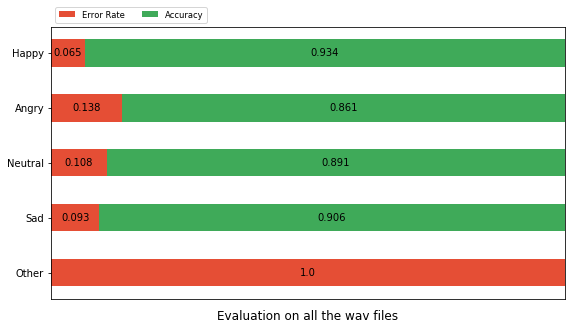

In [61]:
category_names = ['Error Rate', 'Accuracy']
graph_title = 'Evaluation on all the wav files'
results = {
    'Happy': [dictionary_all_h.get('error_rate'), dictionary_all_h.get('accuracy')],
    'Angry': [dictionary_all_a.get('error_rate'), dictionary_all_a.get('accuracy')],
    'Neutral': [dictionary_all_n.get('error_rate'), dictionary_all_n.get('accuracy')],
    'Sad': [dictionary_all_s.get('error_rate'), dictionary_all_s.get('accuracy')],
    'Other': [dictionary_all_o.get('error_rate'), dictionary_all_o.get('accuracy')]
}

draw(results, category_names, graph_title)

In [ ]:
predict_cnn(model)